In [1]:
#Importing the dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

In [2]:
#Storing the csvpaths
csvpath_without_rakuten="Test2_without_rakuten_promo.csv"

In [3]:
test2_df = pd.read_csv(csvpath_without_rakuten)

In [4]:
test2_df.head()

,ProductCategory,SKU,OrderName,Order Date - Year,Order Date - Month,Order Date - Day,Order Date,Sum of Qty,Sum of $ Order,$ Discount,Sum of TotalDiscounts
0,Bed Frame,EY-BFGRY-CLKG2,C272853,2020,8,16,2020-08-16,1,590,$0.,$0.
1,Bed Frame,EY-BFGRY-FL2,C272455,2020,8,16,2020-08-16,1,450,$0.,$0.
2,Bed Frame,EY-BFGRY-FL2,C272472,2020,8,16,2020-08-16,1,450,$67.5,$67.5
3,Bed Frame,EY-BFGRY-FL2,C272493,2020,8,16,2020-08-16,1,450,$0.,$0.
4,Bed Frame,EY-BFGRY-FL2,C272525,2020,8,16,2020-08-16,1,450,$0.,$0.


In [5]:
#Dropping the colums which are not required
test2_df.drop(columns=["SKU","OrderName","Order Date - Year","Order Date - Month","Order Date - Day","$ Discount","Sum of TotalDiscounts"],inplace=True)

In [6]:
#Filling NaN with a 0 for calculations
test2_df = test2_df.fillna(0)
test2_final_df = test2_df
test2_final_df.head()

,ProductCategory,Order Date,Sum of Qty,Sum of $ Order
0,Bed Frame,2020-08-16,1,590
1,Bed Frame,2020-08-16,1,450
2,Bed Frame,2020-08-16,1,450
3,Bed Frame,2020-08-16,1,450
4,Bed Frame,2020-08-16,1,450


In [7]:
#forecasting revenue now

In [8]:
#revenue prep df before arima processing

In [9]:
test2_final_df.drop(columns =["ProductCategory","Sum of Qty"],inplace=True)

In [10]:
test2_final_df.head()

,Order Date,Sum of $ Order
0,2020-08-16,590
1,2020-08-16,450
2,2020-08-16,450
3,2020-08-16,450
4,2020-08-16,450


In [11]:
#groupby order date
revenue_groupby_df = test2_final_df.groupby(["Order Date"])

revenue_groupby_df = revenue_groupby_df.sum()
revenue_groupby_df.head()

,Sum of $ Order
Order Date,
2020-08-16,575210
2020-08-17,531295
2020-08-18,396375
2020-08-19,433605
2020-08-20,374965


In [12]:
revenue_df =pd.DataFrame({
                    "Revenue":revenue_groupby_df.loc[:,"Sum of $ Order"].tolist()
                   })
revenue_df.head()

,Revenue
0,575210
1,531295
2,396375
3,433605
4,374965


In [13]:
revenue_model_mean = revenue_df.rolling(window = 5).mean()
revenue_model_mean.head()

,Revenue
0,NaN
1,NaN
2,NaN
3,NaN
4,462290.0


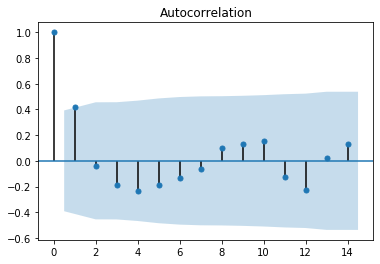

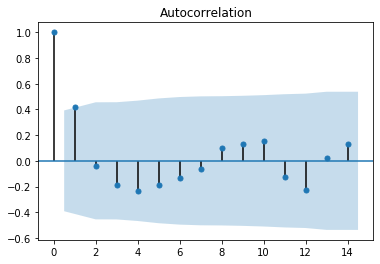

In [14]:
#ARIMA - Autoregressive (p) Integrated (d) Moving Average (q)
#plot_acf is to identify parameter q
#plot_pacf is to identify parameter p
#ARIMA (p,d,q)

plot_acf(revenue_df)

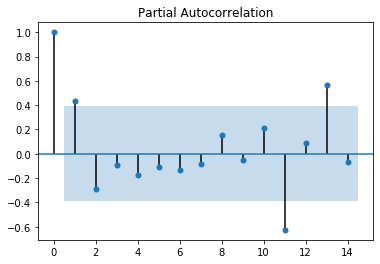

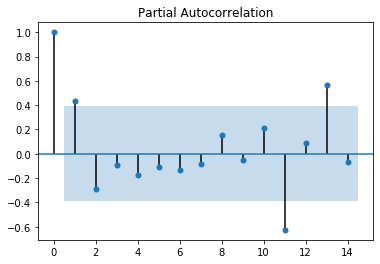

In [15]:
plot_pacf(revenue_df)

In [16]:
train_parameter_revenue = 25

In [17]:
#revenue_test.size >>> 25
revenue_train = revenue_df[0:train_parameter_revenue]
revenue_test = revenue_df[train_parameter_revenue:25]
forecast_step_revenue = revenue_test.size
forecast_step_revenue

0

In [18]:
revenue_model = ARIMA(revenue_train, order=(1,0,1))

In [19]:
revenue_model_fit = revenue_model.fit()
revenue_model_fit.aic

639.531352378703

In [20]:
revenue_forecast = revenue_model_fit.forecast(steps = 10)[0]
revenue_forecast

array([631253.04900931, 547966.08736527, 514290.29822562, 500674.01601539,
       495168.48382252, 492942.40740469, 492042.32798558, 491678.39485453,
       491531.24414642, 491471.74604348])

In [21]:
revenue_predict_df= pd.DataFrame({"Revenue Forecast":revenue_forecast.tolist()})
revenue_predict_df.head()

,Revenue Forecast
0,631253.049009
1,547966.087365
2,514290.298226
3,500674.016015
4,495168.483823


In [22]:
revenue_df.head()

,Revenue
0,575210
1,531295
2,396375
3,433605
4,374965


In [23]:
revenue_prelim_predict_df = pd.concat([revenue_df, revenue_predict_df],sort=False, ignore_index=True)
revenue_prelim_predict_df.tail()

,Revenue,Revenue Forecast
30,NaN,492942.407405
31,NaN,492042.327986
32,NaN,491678.394855
33,NaN,491531.244146
34,NaN,491471.746043


In [24]:
revenue_prelim_predict_df['date'] = pd.date_range(start='08/16/2020',periods=len(revenue_prelim_predict_df),freq='D')
revenue_prelim_predict_df.head()

,Revenue,Revenue Forecast,date
0,575210.0,NaN,2020-08-16
1,531295.0,NaN,2020-08-17
2,396375.0,NaN,2020-08-18
3,433605.0,NaN,2020-08-19
4,374965.0,NaN,2020-08-20


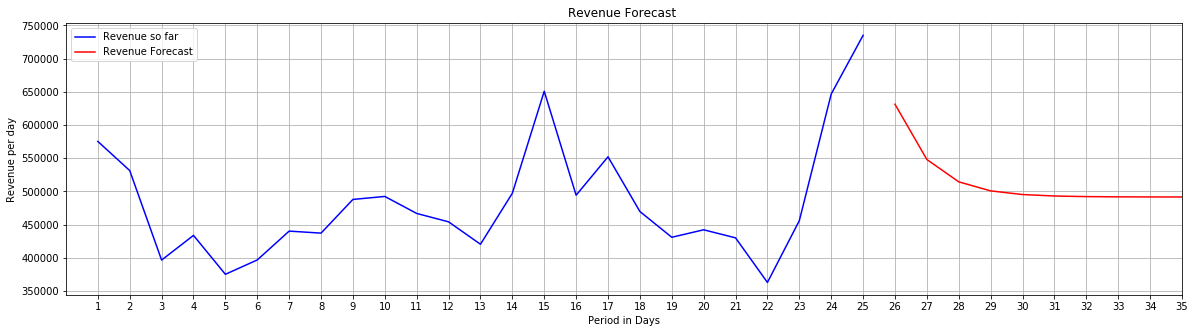

In [25]:
plt.figure(figsize=(20,5))
x_axis = np.arange(1, len(revenue_prelim_predict_df)+1)
tick_locations_revenue = []
for x in x_axis:
    tick_locations_revenue.append(x)
    
plt.title("Revenue Forecast ")
plt.xlabel("Period in Days")
plt.ylabel("Revenue per day")
plt.grid()
plt.xlim(0,len(revenue_prelim_predict_df)-1)
    
revenue, = plt.plot(x_axis, revenue_prelim_predict_df.loc[:,'Revenue'], color="blue", label="Revenue so far")
revenue_forecast, = plt.plot(x_axis, revenue_prelim_predict_df.loc[:,'Revenue Forecast'], color ='red', label = 'Revenue Forecast')

plt.legend(handles=[revenue, revenue_forecast], loc="upper left")
plt.xticks(tick_locations_revenue)

plt.show()

In [26]:
test2_invt_df = pd.read_csv(csvpath_without_rakuten)

In [27]:
test2_invt_df.head()

,ProductCategory,SKU,OrderName,Order Date - Year,Order Date - Month,Order Date - Day,Order Date,Sum of Qty,Sum of $ Order,$ Discount,Sum of TotalDiscounts
0,Bed Frame,EY-BFGRY-CLKG2,C272853,2020,8,16,2020-08-16,1,590,$0.,$0.
1,Bed Frame,EY-BFGRY-FL2,C272455,2020,8,16,2020-08-16,1,450,$0.,$0.
2,Bed Frame,EY-BFGRY-FL2,C272472,2020,8,16,2020-08-16,1,450,$67.5,$67.5
3,Bed Frame,EY-BFGRY-FL2,C272493,2020,8,16,2020-08-16,1,450,$0.,$0.
4,Bed Frame,EY-BFGRY-FL2,C272525,2020,8,16,2020-08-16,1,450,$0.,$0.


In [28]:
#Dropping the colums which are not required
test2_invt_df.drop(columns=["SKU","OrderName","Order Date - Year","Order Date - Month","Order Date - Day","$ Discount","Sum of TotalDiscounts"],inplace=True)

In [29]:
test2_invt_df = test2_invt_df.fillna(0)

In [30]:
test2_invt_df.head()

,ProductCategory,Order Date,Sum of Qty,Sum of $ Order
0,Bed Frame,2020-08-16,1,590
1,Bed Frame,2020-08-16,1,450
2,Bed Frame,2020-08-16,1,450
3,Bed Frame,2020-08-16,1,450
4,Bed Frame,2020-08-16,1,450


In [31]:
test2_invt_df = test2_invt_df[test2_invt_df.ProductCategory != "Bed Frame"]
test2_invt_df.head()

,ProductCategory,Order Date,Sum of Qty,Sum of $ Order
59,Blanket,2020-08-16,1,195
60,Blanket,2020-08-16,1,195
61,Duvet,2020-08-16,1,200
62,Duvet,2020-08-16,1,200
63,Duvet,2020-08-16,1,200


In [32]:
test2_invt_df = test2_invt_df[test2_invt_df.ProductCategory != "Blanket"]
test2_invt_df.head()

,ProductCategory,Order Date,Sum of Qty,Sum of $ Order
61,Duvet,2020-08-16,1,200
62,Duvet,2020-08-16,1,200
63,Duvet,2020-08-16,1,200
64,Duvet,2020-08-16,1,200
65,Duvet,2020-08-16,1,200


In [33]:
test2_invt_df = test2_invt_df[test2_invt_df.ProductCategory != "Duvet"]
test2_invt_df.head()

,ProductCategory,Order Date,Sum of Qty,Sum of $ Order
95,Duvet Cover,2020-08-16,1,125
96,Duvet Cover,2020-08-16,1,100
97,Duvet Cover,2020-08-16,1,100
98,Duvet Cover,2020-08-16,1,90
99,Duvet Cover,2020-08-16,1,95


In [34]:
test2_invt_df = test2_invt_df[test2_invt_df.ProductCategory != "Duvet Cover"]
test2_invt_df.head()

,ProductCategory,Order Date,Sum of Qty,Sum of $ Order
128,Mattress,2020-08-16,1,775
129,Mattress,2020-08-16,1,775
130,Mattress,2020-08-16,1,775
131,Mattress,2020-08-16,1,775
132,Mattress,2020-08-16,1,775


In [35]:
test2_invt_df = test2_invt_df[test2_invt_df.ProductCategory != "Mattress"]
test2_invt_df.head()

,ProductCategory,Order Date,Sum of Qty,Sum of $ Order
629,Mattress Protector,2020-08-16,1,100
630,Mattress Protector,2020-08-16,1,100
631,Mattress Protector,2020-08-16,1,100
632,Mattress Protector,2020-08-16,1,100
633,Mattress Protector,2020-08-16,1,100


In [36]:
test2_invt_df = test2_invt_df[test2_invt_df.ProductCategory != "Mattress Protector"]
test2_invt_df.head()

,ProductCategory,Order Date,Sum of Qty,Sum of $ Order
800,Pillow,2020-08-16,3,240
801,Pillow,2020-08-16,1,80
802,Pillow,2020-08-16,2,160
803,Pillow,2020-08-16,1,80
804,Pillow,2020-08-16,2,160


In [37]:
test2_invt_df = test2_invt_df[test2_invt_df.ProductCategory != "Mattress Cover"]
test2_invt_df.head()

,ProductCategory,Order Date,Sum of Qty,Sum of $ Order
800,Pillow,2020-08-16,3,240
801,Pillow,2020-08-16,1,80
802,Pillow,2020-08-16,2,160
803,Pillow,2020-08-16,1,80
804,Pillow,2020-08-16,2,160


In [38]:
test2_invt_df = test2_invt_df[test2_invt_df.ProductCategory != "Pillow Case"]
test2_invt_df.head()

,ProductCategory,Order Date,Sum of Qty,Sum of $ Order
800,Pillow,2020-08-16,3,240
801,Pillow,2020-08-16,1,80
802,Pillow,2020-08-16,2,160
803,Pillow,2020-08-16,1,80
804,Pillow,2020-08-16,2,160


In [39]:
test2_invt_df.drop(columns =["ProductCategory","Sum of $ Order"],inplace=True)

In [40]:
test2_invt_df.head()

,Order Date,Sum of Qty
800,2020-08-16,3
801,2020-08-16,1
802,2020-08-16,2
803,2020-08-16,1
804,2020-08-16,2


In [41]:
#groupby order date
inventory_groupby_df = test2_invt_df.groupby(["Order Date"])

inventory_groupby_df = inventory_groupby_df.sum()
inventory_groupby_df.head()

,Sum of Qty
Order Date,
2020-08-16,680
2020-08-17,608
2020-08-18,489
2020-08-19,498
2020-08-20,431


In [42]:
inventory_df =pd.DataFrame({"Inventory":inventory_groupby_df.loc[:,"Sum of Qty"].tolist()})
inventory_df.head()

,Inventory
0,680
1,608
2,489
3,498
4,431


In [43]:
inventory_model_mean = inventory_df.rolling(window = 5).mean()
inventory_model_mean.head()

,Inventory
0,NaN
1,NaN
2,NaN
3,NaN
4,541.2


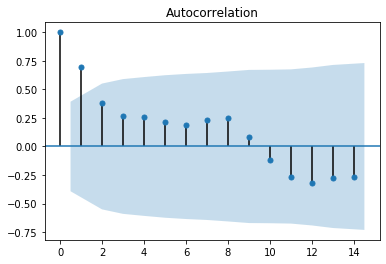

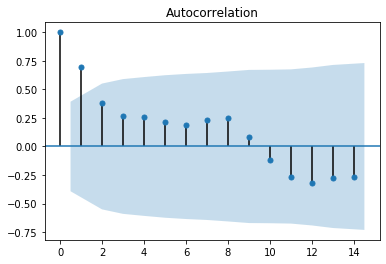

In [44]:
plot_acf(inventory_df)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


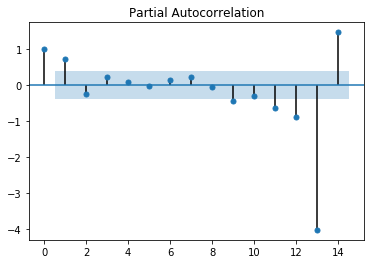

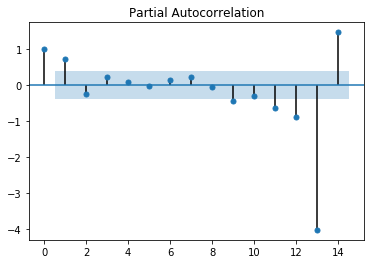

In [45]:
plot_pacf(inventory_df)

In [46]:
train_parameter_inventory = 25

In [47]:
#revenue_test.size >>> 25
inventory_train = inventory_df[0:train_parameter_inventory]
inventory_test = inventory_df[train_parameter_inventory:25]
forecast_step_inventory = inventory_test.size
forecast_step_inventory

0

In [48]:
inventory_model = ARIMA(inventory_train, order=(1,0,1))

In [49]:
inventory_model_fit = inventory_model.fit()
inventory_model_fit.aic

311.3000701651681

In [50]:
inventory_forecast = inventory_model_fit.forecast(steps = 10)[0]
inventory_forecast

array([1346.86902855, 1262.82540492, 1191.90845575, 1132.06794125,
       1081.57384613, 1038.96636419, 1003.01369461,  972.67643009,
        947.07750714,  925.47684978])

In [51]:
inventory_predict_df= pd.DataFrame({"Inventory Forecast":inventory_forecast.tolist()})
inventory_predict_df.head()

,Inventory Forecast
0,1346.869029
1,1262.825405
2,1191.908456
3,1132.067941
4,1081.573846


In [52]:
inventory_prelim_predict_df = pd.concat([inventory_df, inventory_predict_df],sort=False, ignore_index=True)
inventory_prelim_predict_df.tail()

,Inventory,Inventory Forecast
30,NaN,1038.966364
31,NaN,1003.013695
32,NaN,972.676430
33,NaN,947.077507
34,NaN,925.476850


In [53]:
inventory_prelim_predict_df['date'] = pd.date_range(start='08/16/2020',periods=len(inventory_prelim_predict_df),freq='D')
inventory_prelim_predict_df.head()

,Inventory,Inventory Forecast,date
0,680.0,NaN,2020-08-16
1,608.0,NaN,2020-08-17
2,489.0,NaN,2020-08-18
3,498.0,NaN,2020-08-19
4,431.0,NaN,2020-08-20


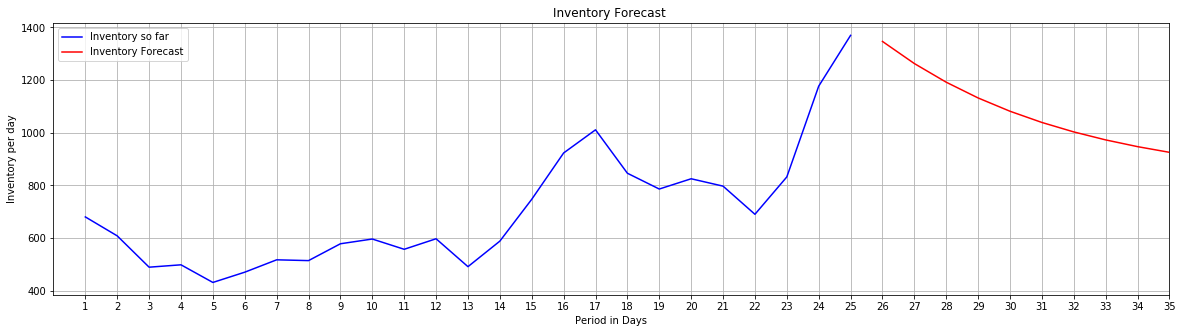

In [54]:
plt.figure(figsize=(20,5))
x_axis = np.arange(1, len(inventory_prelim_predict_df)+1)
tick_locations_inventory = []
for x in x_axis:
    tick_locations_inventory.append(x)
    
plt.title("Inventory Forecast ")
plt.xlabel("Period in Days")
plt.ylabel("Inventory per day")
plt.grid()
plt.xlim(0,len(inventory_prelim_predict_df)-1)
    
inventory, = plt.plot(x_axis, inventory_prelim_predict_df.loc[:,'Inventory'], color="blue", label="Inventory so far")
inventory_forecast, = plt.plot(x_axis, inventory_prelim_predict_df.loc[:,'Inventory Forecast'], color ='red', label = 'Inventory Forecast')

plt.legend(handles=[inventory, inventory_forecast], loc="upper left")
plt.xticks(tick_locations_inventory)

plt.show()